In [4]:
import os
import boto3  # AWS
import pandas as pd
from pandas import json_normalize
import numpy as np
import json
import io

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)
import pandas as pd

# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

# the below extension properly formats a cell after it is run
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [5]:
s3R = boto3.resource("s3")
s3 = boto3.client("s3")
bucket_name = "capstonehaystacks"
# Listing the contents of the S3 bucket to ensure everything looks good
for obj in s3R.Bucket(bucket_name).objects.all():
    print(obj.key)

GA_LISTINGS_SALES.csv
GA_LISTINGS_SALES_V2.csv
GA_listing.csv
all_zips_grocery_store.json
all_zips_restaurant.json
atlanta-geo.csv
atlanta_cbsa_zip.csv
atlanta_hdma_2021.csv
atlanta_hdma_census_2021.csv
atlanta_listings.csv
core_geo_dataset.csv
crime.csv
crime_rating_zipcode.csv
elementary_schools.csv
high_schools.csv
hmda_2021_ga_all-records_labels.csv
listings_with_tract.csv
middle_schools.csv
poi_combined_haystack.csv
points-of-interest-google.csv
points-of-interest-google2.csv
points-of-interest-haystacks.csv
schools.csv


<IPython.core.display.Javascript object>

In [6]:
atlanta_geo = dataframes["atlanta_cbsa_zip"]
geo = dataframes["core_geo_dataset"]

NameError: name 'dataframes' is not defined

<IPython.core.display.Javascript object>

In [7]:
file_name = "GA_LISTINGS_SALES_V2.csv"

file_obj = s3.get_object(Bucket=bucket_name, Key=file_name)
listings = pd.read_csv(file_obj["Body"])

<IPython.core.display.Javascript object>

In [8]:
file_name = "atlanta_cbsa_zip.csv"

file_obj = s3.get_object(Bucket=bucket_name, Key=file_name)
atlanta_geo = pd.read_csv(file_obj["Body"])

<IPython.core.display.Javascript object>

In [9]:
file_name = "core_geo_dataset.csv"

file_obj = s3.get_object(Bucket=bucket_name, Key=file_name)
geo = pd.read_csv(file_obj["Body"])

<IPython.core.display.Javascript object>

# Can you double check the below cell to make sure Im getting the census tracts correctly?

In [10]:
# THIS IS GIVING ME ABOUT 500 CENSUS TRACT NUMBERS AND IT SHOULD BE AT LEAST DOUBLE THAT!


# creating a set of all the zip codes in the atlanta region
zipcode_set = set(atlanta_geo["census_zcta5_geoid"])

# creating a dataframe with values only in the atlanta region
filtered_geo = geo[geo["census_zcta5_geoid"].isin(zipcode_set)]

# using this atlanta dataframe to create a set of census tract ID's
census_tract_set = set(filtered_geo["census_tract_geoid"])

<IPython.core.display.Javascript object>

In [11]:
zipcodes = atlanta_geo["census_zcta5_geoid"].tolist()

<IPython.core.display.Javascript object>

In [18]:
zipcodes[:3]

[30309, 30517, 30548]

<IPython.core.display.Javascript object>

In [13]:
# replacing 'None' values with NaN values
listings['zip'] = listings['zip'].replace('None', np.nan)

# dropping all rows with NaN values
listings = listings.dropna(subset=['zip'])

# converting the 'zip' column to integers
listings['zip'] = listings['zip'].astype(int)


<IPython.core.display.Javascript object>

In [14]:
# dropping rows outside of the Atlanta region
listings = listings[listings['zip'].astype(str).isin([str(z) for z in zipcodes])]

# resetting index
listings = listings.reset_index(drop=True)

# dropping first row which is indexes
listings = listings.drop(columns=listings.columns[0])

# dropping the observations that are listings which dont contain homes
listings = listings[~listings["details"].str.contains("Lots/Land")]

# dropping observations with no baths or beds becasue they seem to be just land or commercial properties
listings = listings.dropna(subset=["beds", "baths_full"])

# filling in missing values for half baths with zero
listings["baths_half"] = listings["baths_half"].fillna(0)

# dropping this column that contains all missing values
listings = listings.drop("unit_count", axis=1)



<IPython.core.display.Javascript object>

In [19]:
census_tract_set

{13013180103,
 13013180104,
 13013180105,
 13013180106,
 13013180107,
 13013180108,
 13013180203,
 13013180204,
 13013180205,
 13013180206,
 13013180301,
 13013180302,
 13013180303,
 13013180401,
 13013180402,
 13013180501,
 13013180502,
 13013180503,
 13015960101,
 13015960801,
 13015960802,
 13015960901,
 13015960902,
 13035150300,
 13045910101,
 13045910103,
 13045910400,
 13045910502,
 13045910600,
 13045910800,
 13045910900,
 13055010100,
 13055010300,
 13055010600,
 13057090905,
 13057091001,
 13057091006,
 13057091007,
 13057091101,
 13059130500,
 13063040202,
 13063040203,
 13063040204,
 13063040302,
 13063040306,
 13063040307,
 13063040308,
 13063040407,
 13063040409,
 13063040410,
 13063040414,
 13063040416,
 13063040417,
 13063040509,
 13063040510,
 13063040512,
 13063040513,
 13063040518,
 13063040519,
 13063040521,
 13063040522,
 13063040523,
 13063040525,
 13063040606,
 13063040609,
 13063040614,
 13063040615,
 13063040617,
 13063980000,
 13067030104,
 13067030107,
 13067

<IPython.core.display.Javascript object>

In [16]:
def add_tracts(places, censusgdf, id_col='GEOID'):
    places_gdf = places_to_geom(places)
    places_gdf = places_gdf.set_crs(censusgdf.crs) # Set the CRS of places_gdf to match censusgdf
    places_gdf = gpd.sjoin(places_gdf, censusgdf[[id_col, 'geometry']], how='left', op='within')
    places_gdf = places_gdf.drop(columns=['index_right'])

    return places_gdf


<IPython.core.display.Javascript object>

In [20]:
print(type(censusgdf))

NameError: name 'censusgdf' is not defined

<IPython.core.display.Javascript object>

In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# converting the dataframe to a geodataframe
listings_gdf = gpd.GeoDataFrame(listings, geometry=[Point(xy) for xy in zip(listings.longitude, listings.latitude)])

# setting the cordinate reference system (CRS) for the listings geodataframe
listings_gdf.crs = censusgdf.crs

# joining the listings geodataframe with the census dataframe
listings_with_tract = gpd.sjoin(listings_gdf, censusgdf, how='left', op='within')

# dropping unnecessary columns
listings_with_tract.drop(['index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'], axis=1, inplace=True)

# renaming the GEOID column to "census_tract_number"
listings_with_tract.rename(columns={'GEOID': 'census_tract_number'}, inplace=True)

# converting the resulting GeoDataFrame back to a DataFrame
listings_with_tract = pd.DataFrame(listings_with_tract)





NameError: name 'censusgdf' is not defined

<IPython.core.display.Javascript object>

# None of the census tracts are in the set of census tract numbers I created

In [22]:
# find out how many numbers are in the census_tract_set
number_of_tracts = len(census_tract_set)
print("Number of tracts in census_tract_set:", number_of_tracts)

#cCount how many times numbers in the set appear in the census_tract_number column
count_in_set = listings_with_tract['census_tract_number'].isin(census_tract_set).sum()
print("Number of times tracts in the set appear in the census_tract_number column:", count_in_set)

# count unique numbers in the census_tract_number column
unique_numbers_in_column = listings_with_tract['census_tract_number'].nunique()

# find out how many numbers in the census_tract_number column do not appear in the set
count_not_in_set = unique_numbers_in_column - count_in_set
print("Number of tracts in the census_tract_number column not in the set:", count_not_in_set)


Number of tracts in census_tract_set: 578


NameError: name 'listings_with_tract' is not defined

<IPython.core.display.Javascript object>

In [23]:
census_tract_set

{13013180103,
 13013180104,
 13013180105,
 13013180106,
 13013180107,
 13013180108,
 13013180203,
 13013180204,
 13013180205,
 13013180206,
 13013180301,
 13013180302,
 13013180303,
 13013180401,
 13013180402,
 13013180501,
 13013180502,
 13013180503,
 13015960101,
 13015960801,
 13015960802,
 13015960901,
 13015960902,
 13035150300,
 13045910101,
 13045910103,
 13045910400,
 13045910502,
 13045910600,
 13045910800,
 13045910900,
 13055010100,
 13055010300,
 13055010600,
 13057090905,
 13057091001,
 13057091006,
 13057091007,
 13057091101,
 13059130500,
 13063040202,
 13063040203,
 13063040204,
 13063040302,
 13063040306,
 13063040307,
 13063040308,
 13063040407,
 13063040409,
 13063040410,
 13063040414,
 13063040416,
 13063040417,
 13063040509,
 13063040510,
 13063040512,
 13063040513,
 13063040518,
 13063040519,
 13063040521,
 13063040522,
 13063040523,
 13063040525,
 13063040606,
 13063040609,
 13063040614,
 13063040615,
 13063040617,
 13063980000,
 13067030104,
 13067030107,
 13067

<IPython.core.display.Javascript object>

<Axes: >

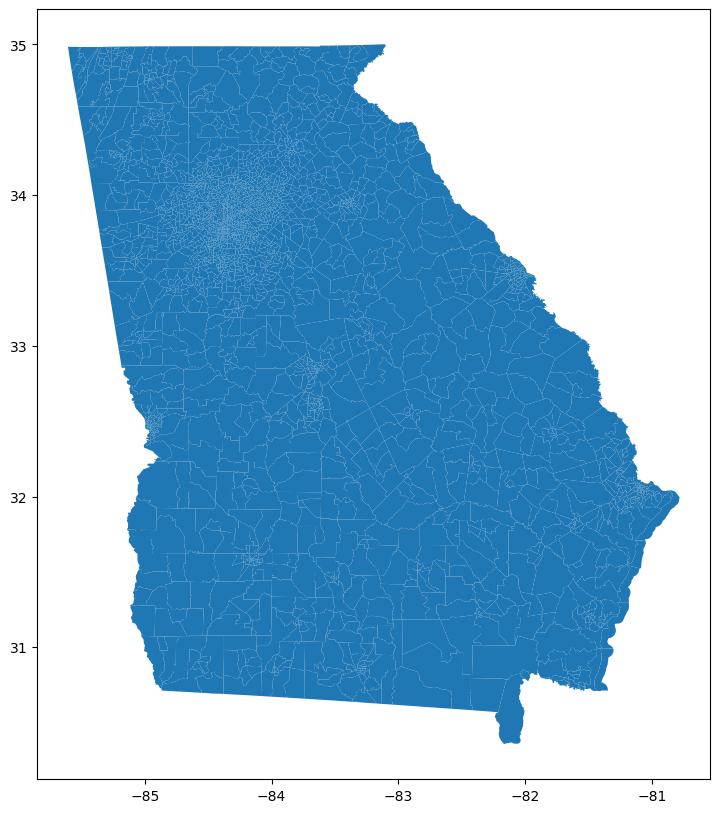

<IPython.core.display.Javascript object>

In [89]:
censusgdf.plot(figsize=(10, 10))


<Axes: >

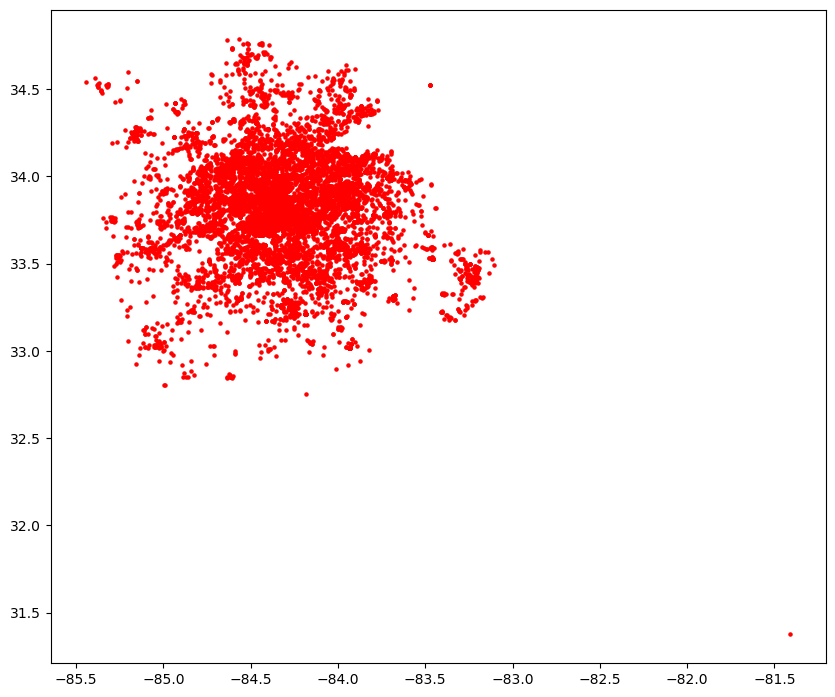

<IPython.core.display.Javascript object>

In [90]:
places_gdf.plot(figsize=(10, 10), color='red', markersize=5)


In [146]:
listings_with_tract

,latitude,longitude,full_street_address,city,county_name,beds,baths_full,baths_half,square_footage,lot_size,year_built,details,special_features,price,transaction_type,listing_status,listing_special_features,census_state_name,census_county_name,zip,census_tract_number
0,33.971863,-83.618736,633 Marigot Way,Statham,Barrow-County,3.0,2.0,0.0,1634.0,1.0,2004.0,"Detached, 3 Beds, 2 Baths, 1,634 Sq Ft",0,305000,1,1,0,Georgia,"Barrow, GA",30666,13013180401
2,34.018024,-83.663994,431 Dunahoo Road,Winder,Barrow-County,3.0,2.0,0.0,1625.0,0.0,1998.0,"Detached, 3 Beds, 2 Baths, 1,625 Sq Ft",0,349900,1,1,0,Georgia,"Barrow, GA",30680,13013180301
3,34.003227,-83.749001,471 Monticello Court,Winder,Barrow-County,4.0,3.0,0.0,1816.0,0.0,2001.0,"Detached, 4 Beds, 3 Baths, 1,816 Sq Ft",0,289900,1,1,0,Georgia,"Barrow, GA",30680,13013180303
4,33.945867,-83.777162,2025 Jessica Drive,Winder,Barrow-County,3.0,2.0,0.0,1332.0,0.0,2014.0,"Detached, 3 Beds, 2 Baths, 1,332 Sq Ft",0,310500,1,1,0,Georgia,"Barrow, GA",30680,13013180501
5,33.995583,-83.704200,286 Martin Luther King jr Drive,Winder,Barrow-County,3.0,2.0,0.0,1060.0,0.0,1999.0,"Detached, 3 Beds, 2 Baths, 1,060 Sq Ft",0,240000,1,1,0,Georgia,"Barrow, GA",30680,13013180203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17025,33.819237,-83.653763,525 Palimino Pass #44,Monroe,Walton-County,4.0,2.0,1.0,2292.0,0.0,2019.0,"Detached, 4 Beds, 2½ Baths, 2,292 Sq Ft",0,329100,1,1,0,Georgia,"Walton, GA",30655,13297110200
17041,33.801158,-83.578125,3560 Highway 186,Good Hope,Walton-County,4.0,3.0,0.0,4000.0,100.0,2005.0,"Detached, 4 Beds, 3 Baths, 4,000 Sq Ft",0,1725000,1,1,0,Georgia,"Walton, GA",30641,13297110200
17047,33.682419,-83.705124,1527 N Cherokee Road,Social Circle,Walton-County,2.0,1.0,0.0,NaN,0.0,1940.0,"Detached, 2 Beds, 1 Bath, 0.94 Acres",0,194900,1,1,0,Georgia,"Walton, GA",30025,13297110801
17070,34.525218,-83.473638,755 Signature Drive,Mount Airy,Habersham-County,3.0,3.0,0.0,1350.0,0.0,2022.0,"Detached, 3 Beds, 3 Baths, 1,350 Sq Ft",2,309900,1,1,2,Georgia,"Habersham, GA",30620,13137000400


<IPython.core.display.Javascript object>

In [147]:
# Converting the DataFrame to a csv buffer in memory
csv_buffer = io.StringIO()
listings_with_tract.to_csv(csv_buffer, index=False)

# Create an S3 resource
s3R = boto3.resource("s3")

# Specifying the name of the bucket
bucket_name = "capstonehaystacks"

# Naming the file for AWS storage
file_name = "listings_with_tract.csv"

# Assigning the output to a variable what is printed
response = s3R.Object(bucket_name, file_name).put(Body=csv_buffer.getvalue())

# Checking the status to confirm it was uploaded
print(f"File uploaded to S3 with ETag: {response['ETag']}")

File uploaded to S3 with ETag: "8f873ae8f0cf8e5d19d7611c34681e49"


<IPython.core.display.Javascript object>